In [36]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import joblib
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix

In [37]:
# Caricamento del dataset
file_path = 'data-istruzioni/Data.xlsx'
data = pd.read_excel(file_path)

# Rimozione colonne inutili
data_cleaned = data.drop(columns=['ID'])

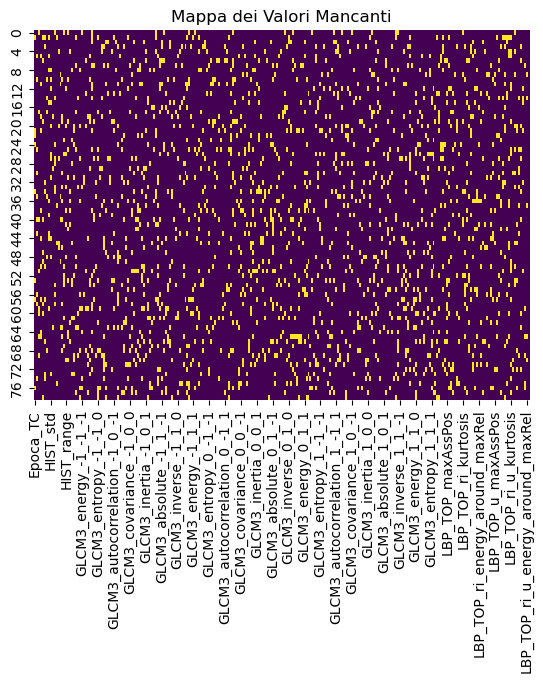

In [38]:
import seaborn as sns
sns.heatmap(data_cleaned.isnull(), cbar=False, cmap='viridis')
plt.title('Mappa dei Valori Mancanti')
plt.show()

In [198]:
#display(data_cleaned.head())
#display(data_cleaned.describe())

In [199]:
#data_cleaned.info()

In [29]:
X = data_cleaned.drop('Recidiva/Non_Recidiva', axis = 1)
y = data_cleaned['Recidiva/Non_Recidiva']

In [39]:
#RANDOM FOREST

# Divisione train/test con proporzione 70%-30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

# Gestione valori mancanti
numerical_imputer = SimpleImputer(strategy='mean')
X_train = pd.DataFrame(numerical_imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(numerical_imputer.transform(X_test), columns=X_test.columns)

# Modello Random Forest
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)

# Predizioni
y_pred = rf.predict(X_test)

# Matrice di Confusione e Report
CM = confusion_matrix(y_test, y_pred)
print("Matrice di Confusione:")
print(CM)
print("Classification Report:")
print(classification_report(y_test, y_pred))


Matrice di Confusione:
[[ 2  7]
 [ 4 11]]
Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.22      0.27         9
           1       0.61      0.73      0.67        15

    accuracy                           0.54        24
   macro avg       0.47      0.48      0.47        24
weighted avg       0.51      0.54      0.52        24



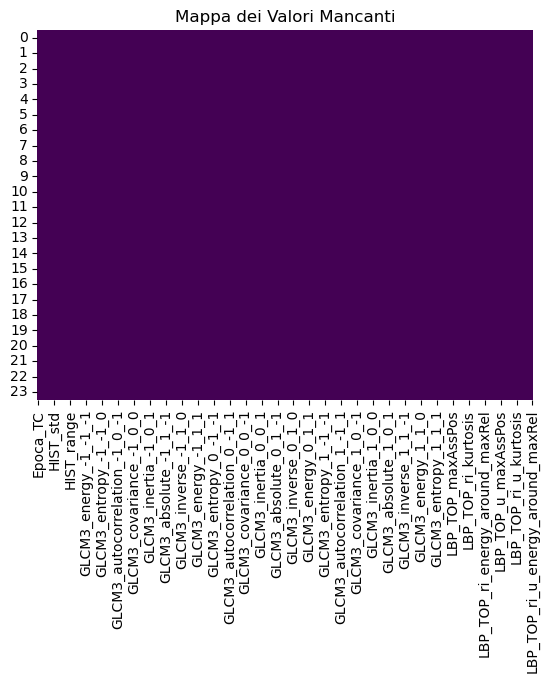

In [41]:
sns.heatmap(X_test.isnull(), cbar=False, cmap='viridis')
plt.title('Mappa dei Valori Mancanti')
plt.show()

In [20]:
# Griglia degli iperparametri
param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'class_weight': ['balanced', None]
}

rf = RandomForestClassifier(random_state=42)

# RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=50, cv=5, scoring='accuracy', random_state=42, verbose=2, n_jobs=-1)
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END class_weight=None, max_depth=30, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END class_weight=None, max_depth=30, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END class_weight=None, max_depth=30, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END class_weight=None, max_depth=30, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END class_weight=None, max_depth=30, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END class_weight=balanced, max_depth=20, max_features=None, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   1.0s
[CV] END class_weight=balanced, max_depth=20, max_features=None, min_samples_leaf=2, min_samples_spl

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'class_weight': ['balanced', None],
                                        'max_depth': [10, 20, 30, None],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400]},
                   random_state=42, scoring='accuracy', verbose=2)

In [21]:
y_pred = random_search.predict(X_test)

CM = confusion_matrix(y_test, y_pred)
print("Matrice di Confusione:")
print(CM)
print("Classification Report:")
print(classification_report(y_test, y_pred))


Matrice di Confusione:
[[4 5]
 [6 9]]
Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.44      0.42         9
           1       0.64      0.60      0.62        15

    accuracy                           0.54        24
   macro avg       0.52      0.52      0.52        24
weighted avg       0.55      0.54      0.55        24



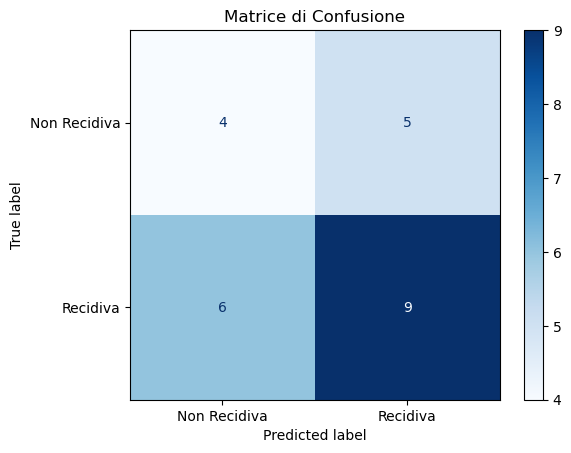

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=CM, display_labels=['Non Recidiva', 'Recidiva'])
disp.plot(cmap='Blues')
plt.title('Matrice di Confusione')
plt.show()

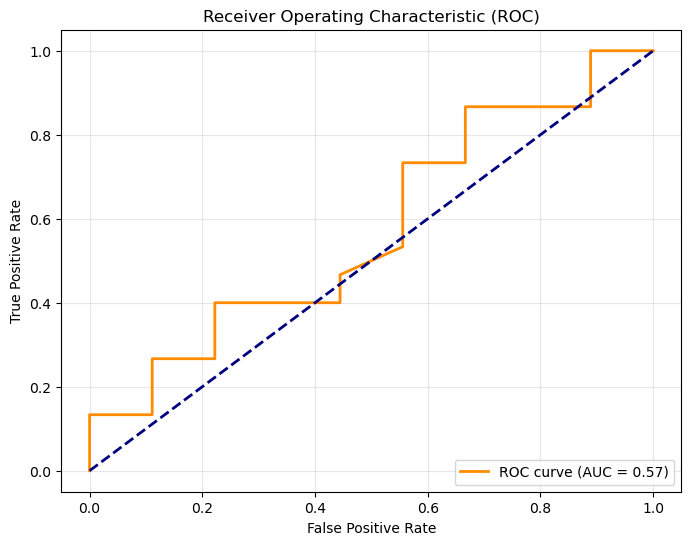

In [24]:
from sklearn.metrics import roc_curve, roc_auc_score

if hasattr(random_search, "predict_proba"):
    y_prob = random_search.predict_proba(X_test)[:, 1]  # Probabilità per la classe positiva


# Calcolo dei valori ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

# Plottaggio della curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

In [30]:
#SVC
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

# Divisione train/test con proporzione 70%-30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

# Gestione valori mancanti
numerical_imputer = SimpleImputer(strategy='mean')
X_train = pd.DataFrame(numerical_imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(numerical_imputer.transform(X_test), columns=X_test.columns)


# Creazione della pipeline per preprocessing e classificatore
svc_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scaling dei dati
    ('svc', SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42))  # Modello SVC
])


svc_pipeline.fit(X_train, y_train)

# Predizioni
y_pred = svc_pipeline.predict(X_test)

# Matrice di confusione e report
CM = confusion_matrix(y_test, y_pred)
print("Matrice di Confusione:")
print(CM)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Matrice di Confusione:
[[ 2  7]
 [ 2 13]]

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.22      0.31         9
           1       0.65      0.87      0.74        15

    accuracy                           0.62        24
   macro avg       0.57      0.54      0.53        24
weighted avg       0.59      0.62      0.58        24



In [42]:
from sklearn.model_selection import GridSearchCV

# Griglia di iperparametri
param_grid = {
    'svc__C': [0.1, 1, 10, 100],
    'svc__gamma': [1, 0.1, 0.01, 0.001, 'scale'],
    'svc__kernel': ['rbf', 'linear', 'poly']
}

# GridSearchCV
grid_search = GridSearchCV(svc_pipeline, param_grid, cv=5, scoring='accuracy', verbose=2)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

best_svc = grid_search.best_estimator_
y_pred = best_svc.predict(X_test)

# Matrice di Confusione e Report
CM = confusion_matrix(y_test, y_pred)
print("Matrice di Confusione:")
print(CM)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END ..........svc__C=0.1, svc__gamma=1, svc__kernel=rbf; total time=   0.0s
[CV] END ..........svc__C=0.1, svc__gamma=1, svc__kernel=rbf; total time=   0.0s
[CV] END ..........svc__C=0.1, svc__gamma=1, svc__kernel=rbf; total time=   0.0s
[CV] END ..........svc__C=0.1, svc__gamma=1, svc__kernel=rbf; total time=   0.0s
[CV] END ..........svc__C=0.1, svc__gamma=1, svc__kernel=rbf; total time=   0.0s
[CV] END .......svc__C=0.1, svc__gamma=1, svc__kernel=linear; total time=   0.0s
[CV] END .......svc__C=0.1, svc__gamma=1, svc__kernel=linear; total time=   0.0s
[CV] END .......svc__C=0.1, svc__gamma=1, svc__kernel=linear; total time=   0.0s
[CV] END .......svc__C=0.1, svc__gamma=1, svc__kernel=linear; total time=   0.0s
[CV] END .......svc__C=0.1, svc__gamma=1, svc__kernel=linear; total time=   0.0s
[CV] END .........svc__C=0.1, svc__gamma=1, svc__kernel=poly; total time=   0.0s
[CV] END .........svc__C=0.1, svc__gamma=1, svc

In [43]:
print("Classification Report:")
print(classification_report(y_test,
                            y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.67      0.63         9
           1       0.79      0.73      0.76        15

    accuracy                           0.71        24
   macro avg       0.69      0.70      0.70        24
weighted avg       0.72      0.71      0.71        24



In [44]:
print("Distribuzione delle classi nel training set:")
print(y_train.value_counts())
print("\nDistribuzione delle classi nel test set:")
print(y_test.value_counts())


Distribuzione delle classi nel training set:
1    30
0    25
Name: Recidiva/Non_Recidiva, dtype: int64

Distribuzione delle classi nel test set:
1    15
0     9
Name: Recidiva/Non_Recidiva, dtype: int64


In [248]:
# Valutazione globale del modello
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nMetriche globali sul Test Set:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")


Metriche globali sul Test Set:
Accuracy: 0.71
Precision: 0.79
Recall: 0.73
F1-Score: 0.76


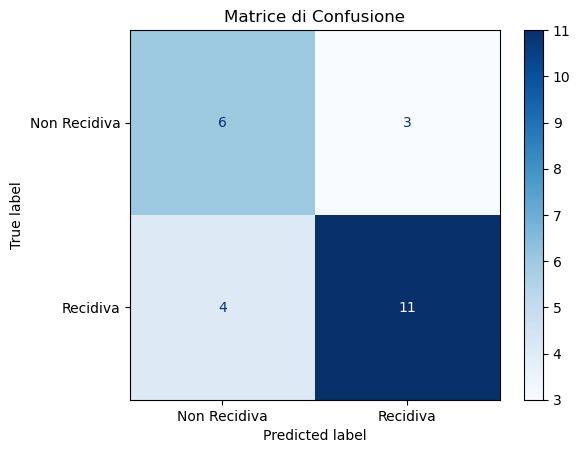

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=CM, display_labels=['Non Recidiva', 'Recidiva'])
disp.plot(cmap='Blues')
plt.title('Matrice di Confusione')
plt.show()

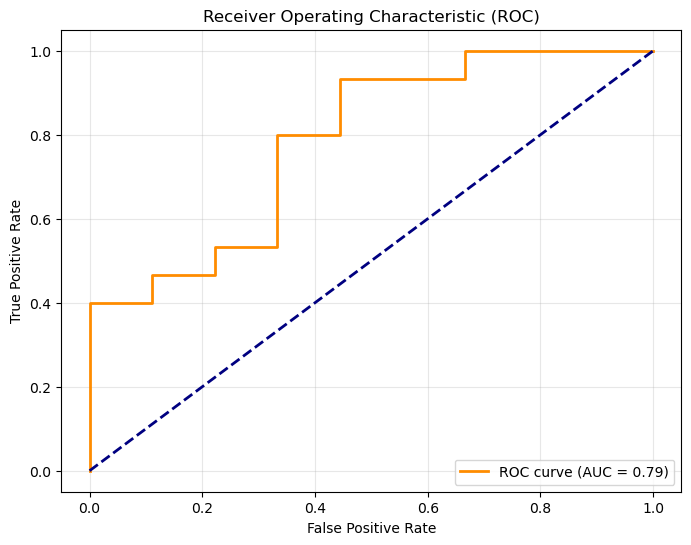

In [34]:
from sklearn.metrics import roc_curve, roc_auc_score

if hasattr(grid_search, "decision_function"):
    y_prob = grid_search.decision_function(X_test)

# Calcolo dei valori ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

# Plottaggio della curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

In [ ]:
#SVC
# Funzione per testare tutti i dati nel test set
def test_full_test_set():
    """
    Testa il modello SVC sui dati del test set e calcola l'accuratezza.
    
    """
    # Predizioni sul test set
    predictions = best_svc.predict(X_test)

    # Calcolo dell'accuratezza
    correct_predictions = (y_test == predictions).sum()
    total_predictions = len(y_test)
    accuracy_on_test = correct_predictions / total_predictions

    print("\nRisultati sui dati del Test Set:")
    for i, pred in enumerate(predictions):
        print(f"Esempio {i+1}: {'Recidiva' if pred == 1 else 'Non Recidiva'} "
              f"(Reale: {'Recidiva' if y_test.iloc[i] == 1 else 'Non Recidiva'})")

    print(f"\nNumero di predizioni corrette: {correct_predictions}")
    print(f"Totale predizioni: {total_predictions}")
    print(f"Accuracy sul Test Set: {accuracy_on_test:.2f}")

In [252]:
test_full_test_set()


Risultati sui dati del Test Set:
Esempio 1: Recidiva (Reale: Recidiva)
Esempio 2: Non Recidiva (Reale: Non Recidiva)
Esempio 3: Recidiva (Reale: Recidiva)
Esempio 4: Non Recidiva (Reale: Recidiva)
Esempio 5: Recidiva (Reale: Recidiva)
Esempio 6: Non Recidiva (Reale: Recidiva)
Esempio 7: Non Recidiva (Reale: Non Recidiva)
Esempio 8: Recidiva (Reale: Recidiva)
Esempio 9: Recidiva (Reale: Non Recidiva)
Esempio 10: Recidiva (Reale: Recidiva)
Esempio 11: Recidiva (Reale: Non Recidiva)
Esempio 12: Non Recidiva (Reale: Non Recidiva)
Esempio 13: Recidiva (Reale: Recidiva)
Esempio 14: Recidiva (Reale: Recidiva)
Esempio 15: Non Recidiva (Reale: Recidiva)
Esempio 16: Recidiva (Reale: Recidiva)
Esempio 17: Non Recidiva (Reale: Non Recidiva)
Esempio 18: Non Recidiva (Reale: Non Recidiva)
Esempio 19: Non Recidiva (Reale: Non Recidiva)
Esempio 20: Non Recidiva (Reale: Recidiva)
Esempio 21: Recidiva (Reale: Recidiva)
Esempio 22: Recidiva (Reale: Non Recidiva)
Esempio 23: Recidiva (Reale: Recidiva)
Es